Nama : Suwandi Ramadhan


# Project 3 - Voice Recognition

## Data & Algoritma Understanding

### Data Understanding

| Nama Dataaset | MINDS-14 (Multilingual Intent Navigation and Discovery in 14 languages) |
|---------------|-------------------------------------------------------------------------|
| Pembuat | PolyAI |
| Deskripsi Singkat | Ini adalah dataset audio yang sangat populer untuk melatih dan mengevaluasi model Spoken Language Understanding (SLU), terutama untuk tugas klasifikasi niat (intent classification). Dataset ini berisi rekaman suara orang-orang yang memberikan perintah atau pertanyaan terkait domain perbankan online. |
| Isi Dataset | - File audio dalam format .wav <br> - Transkripsi teks dari setiap file audio. <br> - Label niat (intent) untuk setiap rekaman. Contoh niatnya seperti pay_bill (bayar tagihan), transfer (transfer uang), balance (cek saldo), dll. |
| Fitur Utama | Multilingual |

### Daftar Bahasa dan Kode Konfigurasi

Kode bahasa (`name`) :

- `cs-CZ` (Czech)
- `de-DE` (German)
- `en-AU` (English, Australia)
- `en-GB` (English, UK)
- `en-US` (English, US)
- `es-ES` (Spanish)
- `fr-FR` (French)
- `it-IT` (Italian)
- `ko-KR` (Korean)
- `nl-NL` (Dutch)
- `pl-PL` (Polish)
- `pt-PT` (Portuguese)
- `ru-RU` (Russian)
- `zh-CN` (Chinese, Mandarin)

### Data Fields

| Nama | Tipe | Deskripsi |
|------|------|-----------|
| `path` | string | Path to the audio file |
| `audio` | dict | Audio object including loaded audio array, sampling rate and path ot audio |
| `transcription` | string | Transcription of the audio file |
| `english_transcription` | string | English transcription of the audio file |
| `intent_class` | integer | Class id of intent |
| `lang_id` | integer | Id of language | 

### Citation Information

`author`     : Daniela Gerz and Pei{-}Hao Su and Razvan Kusztos and Avishek Mondal and Michal Lis and Eshan Singhal and Nikola Mrksic and Tsung{-}Hsien Wen and Ivan Vulic<br> 
`title`      : Multilingual and Cross-Lingual Intent Detection from Spoken Data<br>
`journal`    : CoRR<br>
`volume`     : abs/2104.08524<br>
`year`       : 2021<br>
`url`        : https://arxiv.org/abs/2104.08524<br>
`eprinttype` : arXiv<br>
`eprint`     : 2104.08524<br>
`timestamp`  : Mon, 26 Apr 2021 17:25:10 +0200<br>
`biburl`     : https://dblp.org/rec/journals/corr/abs-2104-08524.bib<br>
`bibsource`  : dblp computer science bibliography, https://dblp.org

## Algoritma Understanding 

# Model Training & Evaluation

#### Import Library

In [1]:
# [Cell 1] Install dan Import
!pip install datasets librosa torch torchaudio soundfile scikit-learn jiwer matplotlib -q

import os, random
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.preprocessing import OneHotEncoder
from datasets import load_dataset, Audio
from jiwer import wer, cer

C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# [Cell 2] Konfigurasi
LANG = 'en-US'
SAMPLE_RATE = 16000
N_MFCC = 13
BATCH_SIZE = 8
NUM_EPOCHS = 10

In [4]:
# [Cell 3] Load dataset & split
raw_dataset = load_dataset("PolyAI/minds14", LANG)
if 'validation' not in raw_dataset:
    split1 = raw_dataset['train'].train_test_split(test_size=0.2, seed=42)
    train_valid = split1['train']
    test_data = split1['test']
    split2 = train_valid.train_test_split(test_size=0.1, seed=42)
    train_data = split2['train']
    val_data = split2['test']
else:
    train_data, val_data, test_data = raw_dataset['train'], raw_dataset['validation'], raw_dataset['test']

# Pastikan audio dikonversi ke sample rate sesuai
train_data = train_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))
val_data = val_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))
test_data = test_data.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE))


In [5]:
# [Cell 4] Token mapping + OneHotEncoder
transcript_col = next(k for k, v in train_data[0].items() if isinstance(v, str))
tokens = sorted(set(c for ex in train_data for c in ex[transcript_col].lower()) | {'<unk>', ' '})
char2idx = {c: i for i, c in enumerate(tokens)}
idx2char = {i: c for i, c in enumerate(tokens)}
vocab_size = len(tokens)

ohe = OneHotEncoder(sparse_output=False, categories=[list(tokens)])
ohe.fit(np.array(tokens).reshape(-1, 1))

,categories,"[[' ', '-', ...]]"
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [12]:
# [Cell 5] Augmentasi & SpecAugment

def augment(audio):
    noise = np.random.randn(len(audio)) * 0.005
    audio += noise
    # Stretching requires STFT-based representation
    audio_stretched = librosa.effects.time_stretch(librosa.util.fix_length(audio, size=20480), rate=random.uniform(0.9, 1.1))
    return librosa.effects.pitch_shift(audio_stretched, sr=SAMPLE_RATE, n_steps=random.randint(-2, 2))

def spec_augment(mfcc):
    t, f = mfcc.shape
    mfcc[np.random.randint(0, t//2):][:random.randint(5, 15), :] = 0
    mfcc[:, np.random.randint(0, f//2):][:, :random.randint(2, 6)] = 0
    return mfcc

In [13]:
# [Cell 6] Dataset & Collate
class SpeechDataset(Dataset):
    def __init__(self, data, augment_prob=0.5):
        self.data = data
        self.augment_prob = augment_prob

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]
        audio, _ = librosa.load(ex['audio']['path'], sr=SAMPLE_RATE)
        if random.random() < self.augment_prob:
            audio = augment(audio)
        mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC).T
        if random.random() < 0.5:
            mfcc = spec_augment(mfcc)
        return mfcc, ex[transcript_col].lower()

def collate_fn(batch):
    specs, texts = zip(*batch)
    lengths = [s.shape[0] for s in specs]
    max_len = max(lengths)
    padded = [np.vstack([s, np.zeros((max_len - s.shape[0], N_MFCC))]) for s in specs]
    X = torch.tensor(padded, dtype=torch.float32)
    mean, std = X.mean((0,1), keepdim=True), X.std((0,1), keepdim=True) + 1e-5
    X = (X - mean) / std
    targets, target_lengths = [], []
    for t in texts:
        chars = np.array(list(t)).reshape(-1, 1)
        onehots = ohe.transform(chars)
        targets.append(torch.tensor(onehots, dtype=torch.float32))
        target_lengths.append(onehots.shape[0])
    max_target_len = max(target_lengths)
    padded_targets = torch.zeros(len(texts), max_target_len, vocab_size)
    for i, t in enumerate(targets):
        padded_targets[i, :t.size(0), :] = t
    return X, torch.tensor(lengths), padded_targets, torch.tensor(target_lengths)

train_loader = DataLoader(SpeechDataset(train_data), BATCH_SIZE, True, collate_fn=collate_fn)
val_loader = DataLoader(SpeechDataset(val_data, 0.0), BATCH_SIZE, False, collate_fn=collate_fn)
test_loader = DataLoader(SpeechDataset(test_data, 0.0), BATCH_SIZE, False, collate_fn=collate_fn)


In [25]:
# [Cell 7] Model BiLSTM
class CNNBiLSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3), padding=1), nn.ReLU()
        )
        self.rnn = nn.LSTM(N_MFCC * 64, 256, num_layers=2, bidirectional=True, batch_first=True, dropout=0.1)
        self.norm = nn.LayerNorm(512)
        self.fc = nn.Linear(512, vocab_size)

    def forward(self, x, lengths):
        x = self.conv(x.unsqueeze(1))  # (B, C, T, F)
        B, C, T, F = x.size()
        x = x.permute(0, 2, 3, 1).reshape(B, T, F * C)  # (B, T, F * C)
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        out, _ = self.rnn(packed)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        return self.fc(self.norm(unpacked)).log_softmax(dim=-1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNBiLSTMModel().to(device)
model.device = device


In [26]:
# [Cell 8] Ganti One-Hot target ke integer index untuk CTCLoss

def onehot_to_index(onehot_targets, target_lengths):
    indices = []
    for i, length in enumerate(target_lengths):
        vector = onehot_targets[i, :length, :]
        idx = vector.argmax(dim=-1)
        indices.extend(idx.tolist())
    return torch.tensor(indices, dtype=torch.long)

In [27]:
# [Cell 9] Training & Evaluasi
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
scaler = GradScaler()

def greedy_decode(logits):
    pred_ids = logits.argmax(dim=-1).cpu().numpy()
    results = []
    for seq in pred_ids:
        prev = -1
        pred = []
        for i in seq:
            if i != prev and i != 0:
                pred.append(idx2char.get(i, ''))
            prev = i
        results.append(''.join(pred))
    return results

def evaluate(loader):
    model.eval(); preds, refs = [], []
    with torch.no_grad():
        for X, spec_lens, y_hot, y_lens in loader:
            X = X.to(device)
            with autocast():
                logits = model(X, spec_lens.to(model.device))
            preds.extend(greedy_decode(logits.cpu()))
            y_flat = onehot_to_index(y_hot, y_lens)
            idx = 0
            for length in y_lens:
                ref_seq = y_flat[idx:idx+length].cpu().numpy()
                refs.append(''.join(idx2char[int(c)] for c in ref_seq))
                idx += length
    return wer(refs, preds), cer(refs, preds)

train_losses, val_wers, val_cers = [], [], []
for epoch in range(NUM_EPOCHS):
    model.train(); total_loss = 0
    for X, spec_lens, y_hot, y_lens in train_loader:
        X = X.to(model.device)
        spec_lens = spec_lens.to(device)
        y_flat = onehot_to_index(y_hot, y_lens).to(device)
        optimizer.zero_grad()
        with autocast():
            logits = model(X, spec_lens)
            logit_lens = torch.full((logits.size(0),), logits.size(1), dtype=torch.long).to(device)
            loss = criterion(logits.permute(1, 0, 2), y_flat, logit_lens, y_lens)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
    scheduler.step()
    val_wer, val_cer = evaluate(val_loader)
    train_losses.append(total_loss / len(train_loader))
    val_wers.append(val_wer); val_cers.append(val_cer)
    print(f"Epoch {epoch+1}: Loss {train_losses[-1]:.4f}, WER {val_wer:.3f}, CER {val_cer:.3f}")
    if val_wer == min(val_wers):
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model terbaik disimpan ke best_model.pth")

C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAA

Epoch 1: Loss 5.9899, WER 1.000, CER 1.000
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 2: Loss 5.2554, WER 1.000, CER 1.000
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 3: Loss 3.5658, WER 1.000, CER 0.997
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 4: Loss 3.5178, WER 1.000, CER 1.000
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 5: Loss 3.1563, WER 1.000, CER 0.993
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 6: Loss 2.9962, WER 1.000, CER 0.990
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 7: Loss 3.1218, WER 1.000, CER 0.986
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 8: Loss 3.0677, WER 1.000, CER 0.988
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 9: Loss 3.3453, WER 1.000, CER 0.990
✅ Model terbaik disimpan ke best_model.pth


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData

Epoch 10: Loss 3.0486, WER 1.000, CER 0.986
✅ Model terbaik disimpan ke best_model.pth


In [30]:
# [Cell 10] Evaluasi akhir dan Simpan Prediksi
final_wer, final_cer = evaluate(test_loader)
print(f"\nFinal Test WER: {final_wer:.3f}, CER: {final_cer:.3f}")
print(f"\nFinal Test WER: {final_wer:.3f}, CER: {final_cer:.3f}")


# [Tambahan] Simpan hasil prediksi ke file CSV
import pandas as pd

def predict_and_save(loader, save_path="predictions.csv"):
    model.eval(); preds, refs = [], []
    with torch.no_grad():
        for X, spec_lens, y_hot, y_lens in loader:
            X = X.to(model.device)
            with autocast():
                logits = model(X, spec_lens.to(model.device))
            batch_preds = greedy_decode(logits.cpu())
            preds.extend(batch_preds)

            y_flat = onehot_to_index(y_hot, y_lens)
            idx = 0
            for length in y_lens:
                ref_seq = y_flat[idx:idx+length].cpu().numpy()
                refs.append(''.join(idx2char[int(c)] for c in ref_seq))
                idx += length

    df = pd.DataFrame({"Reference": refs, "Prediction": preds})
    df.to_csv(save_path, index=False)
    print(f"Saved predictions to {save_path}")
    return df

C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData


Final Test WER: 1.000, CER: 0.986

Final Test WER: 1.000, CER: 0.986


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\564950286.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\2630024082.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_23548\2630024082.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\SUWAAAN\AppDa

Saved predictions to predictions.csv


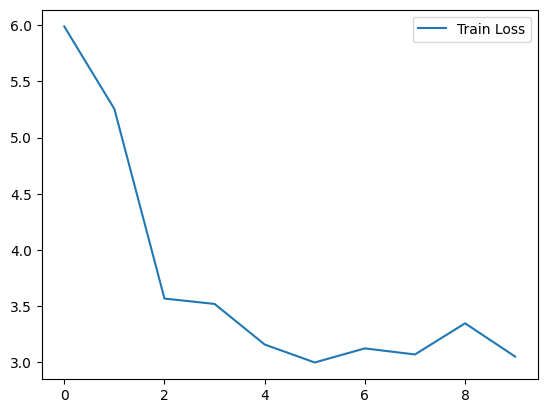

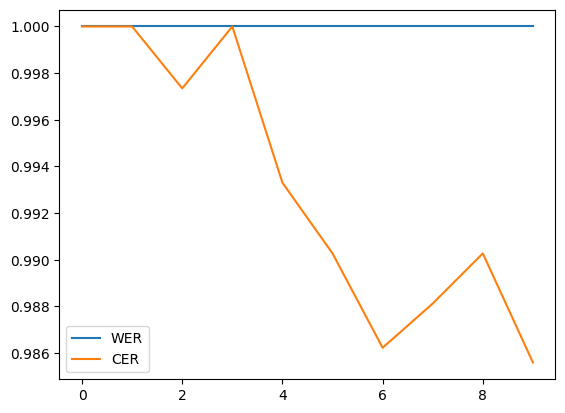

In [31]:
# Simpan hasil evaluasi test
results_df = predict_and_save(test_loader)
plt.plot(train_losses, label='Train Loss'); plt.legend(); plt.show()
plt.plot(val_wers, label='WER'); plt.plot(val_cers, label='CER'); plt.legend(); plt.show()

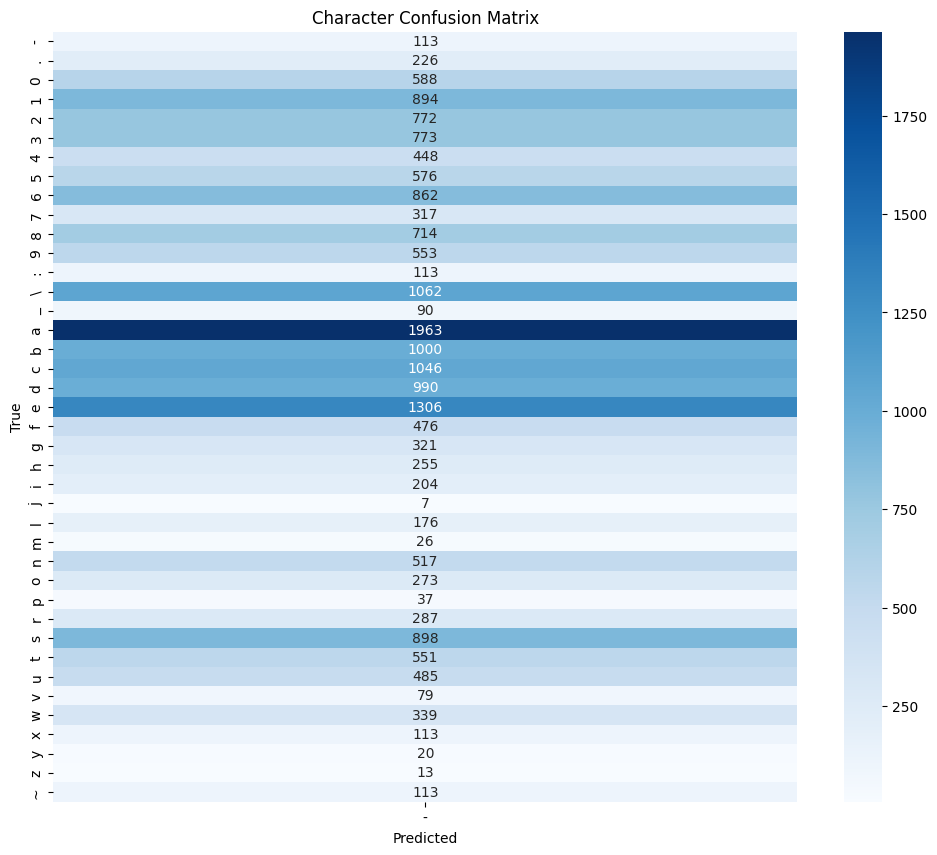


Final Test WER: 1.000, CER: 0.986
a → -: 1963x
e → -: 1306x
\ → -: 1062x
c → -: 1046x
b → -: 1000x
d → -: 990x
s → -: 898x
1 → -: 894x
6 → -: 862x
3 → -: 773x
2 → -: 772x
8 → -: 714x
0 → -: 588x
5 → -: 576x
9 → -: 553x


In [37]:
# [Tambahan Analisis Error] Confusion-like report
from collections import Counter
from difflib import SequenceMatcher

char_errors = Counter()

for ref, hyp in zip(results_df['Reference'], results_df['Prediction']):
    matcher = SequenceMatcher(None, ref, hyp)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            for r, h in zip(ref[i1:i2], hyp[j1:j2]):
                char_errors[(r, h)] += 1
        elif tag == 'delete':
            for r in ref[i1:i2]:
                char_errors[(r, '-')]+= 1
        elif tag == 'insert':
            for h in hyp[j1:j2]:
                char_errors[('-', h)]+= 1

import seaborn as sns
conf_matrix = pd.DataFrame.from_dict(char_errors, orient='index', columns=['count']).reset_index()
conf_matrix[['true', 'pred']] = pd.DataFrame(conf_matrix['index'].tolist(), index=conf_matrix.index)
conf_pivot = conf_matrix.pivot_table(index='true', columns='pred', values='count', fill_value=0)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Character Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"\nFinal Test WER: {final_wer:.3f}, CER: {final_cer:.3f}")
for (r, h), count in char_errors.most_common(15):
    print(f"{r} → {h}: {count}x")
